In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
import os
os.chdir('./drive/My Drive/TESI/Autoencoder')

Mounted at /content/drive/


In [2]:
import pickle as pickle
import math

from src import BikeNYC
import numpy as np

np.random.seed(1337)  # for reproducibility

# parameters
DATAPATH = '../data' 
nb_epoch = 100  # number of epoch at training stage
# nb_epoch_cont = 150  # number of epoch at training (cont) stage
batch_size = 16  # batch size
T = 24  # number of time intervals in one day
CACHEDATA = True  # cache data or NOT

lr = 0.00015  # learning rate
len_closeness = 3  # length of closeness dependent sequence
len_period = 1  # length of peroid dependent sequence
len_trend = 1  # length of trend dependent sequence

nb_flow = 2  # there are two types of flows: new-flow and end-flow
# divide data into two subsets: Train & Test, of which the test set is the
# last 10 days
days_test = 10
len_test = T*days_test
len_val = 2*len_test

map_height, map_width = 16, 8  # grid size
# For NYC Bike data, there are 81 available grid-based areas, each of
# which includes at least ONE bike station. Therefore, we modify the final
# RMSE by multiplying the following factor (i.e., factor).
nb_area = 81
m_factor = math.sqrt(1. * map_height * map_width / nb_area)
# print('factor: ', m_factor)

path_cache = os.path.join(DATAPATH, 'CACHE', 'Autoencoder')  # cache path
path_result = 'RET'
path_model = 'MODEL'
if os.path.isdir(path_result) is False:
    os.mkdir(path_result)
if os.path.isdir(path_model) is False:
    os.mkdir(path_model)
if CACHEDATA and os.path.isdir(path_cache) is False:
    os.mkdir(path_cache)

In [3]:
from utils import cache, read_cache
import time

print("loading data...")
fname = os.path.join(path_cache, 'BikeNYC_C{}_P{}_T{}.h5'.format(
    len_closeness, len_period, len_trend))
if os.path.exists(fname) and CACHEDATA:
    X_train_all, Y_train_all, X_train, Y_train, \
    X_val, Y_val, X_test, Y_test, mmn, external_dim, \
    timestamp_train_all, timestamp_train, timestamp_val, timestamp_test = read_cache(
        fname)
    print("load %s successfully" % fname)
else:
    X_train_all, Y_train_all, X_train, Y_train, \
    X_val, Y_val, X_test, Y_test, mmn, external_dim, \
    timestamp_train_all, timestamp_train, timestamp_val, timestamp_test = BikeNYC.load_data(
        T=T, nb_flow=nb_flow, len_closeness=len_closeness, len_period=len_period, len_trend=len_trend, len_test=len_test,
        len_val=len_val, preprocess_name='preprocessing_nyc.pkl', meta_data=True, datapath=DATAPATH)
    if CACHEDATA:
        cache(fname, X_train_all, Y_train_all, X_train, Y_train, X_val, Y_val, X_test, Y_test,
              external_dim, timestamp_train_all, timestamp_train, timestamp_val, timestamp_test)

print("\n days (test): ", [v[:8] for v in timestamp_test[0::T]])

loading data...


/content/drive/My Drive/TESI/Autoencoder/src/__init__.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = f['data'].value
/content/drive/My Drive/TESI/Autoencoder/src/__init__.py:12: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  timestamps = f['date'].value


4392
incomplete days:  []
train_data shape:  (4152, 2, 16, 8)
min: 0.0 max: 267.0
169
XC shape:  (4223, 6, 16, 8) XP shape:  (4223, 4, 16, 8) XT shape:  (4223, 4, 16, 8) Y shape: (4223, 2, 16, 8)
_XC shape:  (4223, 6, 16, 8) _XP shape: (4223, 4, 16, 8) _XT shape: (4223, 4, 16, 8)
(3983, 16, 8, 14)
(3983, 8)

(3743, 16, 8, 14)
(3743, 8)

(240, 16, 8, 14)
(240, 8)

(240, 16, 8, 14)
(240, 8)


 days (test):  [b'20140921', b'20140922', b'20140923', b'20140924', b'20140925', b'20140926', b'20140927', b'20140928', b'20140929', b'20140930']


In [4]:
mmn._max

267.0

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from utils import build_model

model_name = 'model1'

model = build_model(
    len_closeness, len_period, len_trend, nb_flow, map_height, map_width,
    model = model_name,
    external_dim=external_dim, lr=lr,
    encoder_blocks=2,
    filters=[32,64,16],
    # save_model_pic='BikeNYC_model'
)
# model.summary()
hyperparams_name = '{}.BikeNYC.c{}.p{}.t{}.lr{}'.format(
    model_name, len_closeness, len_period, len_trend, lr)
fname_param = os.path.join('MODEL', '{}.best.h5'.format(hyperparams_name))

early_stopping = EarlyStopping(monitor='val_rmse', patience=5, mode='min')
model_checkpoint = ModelCheckpoint(
    fname_param, monitor='val_rmse', verbose=0, save_best_only=True, mode='min')

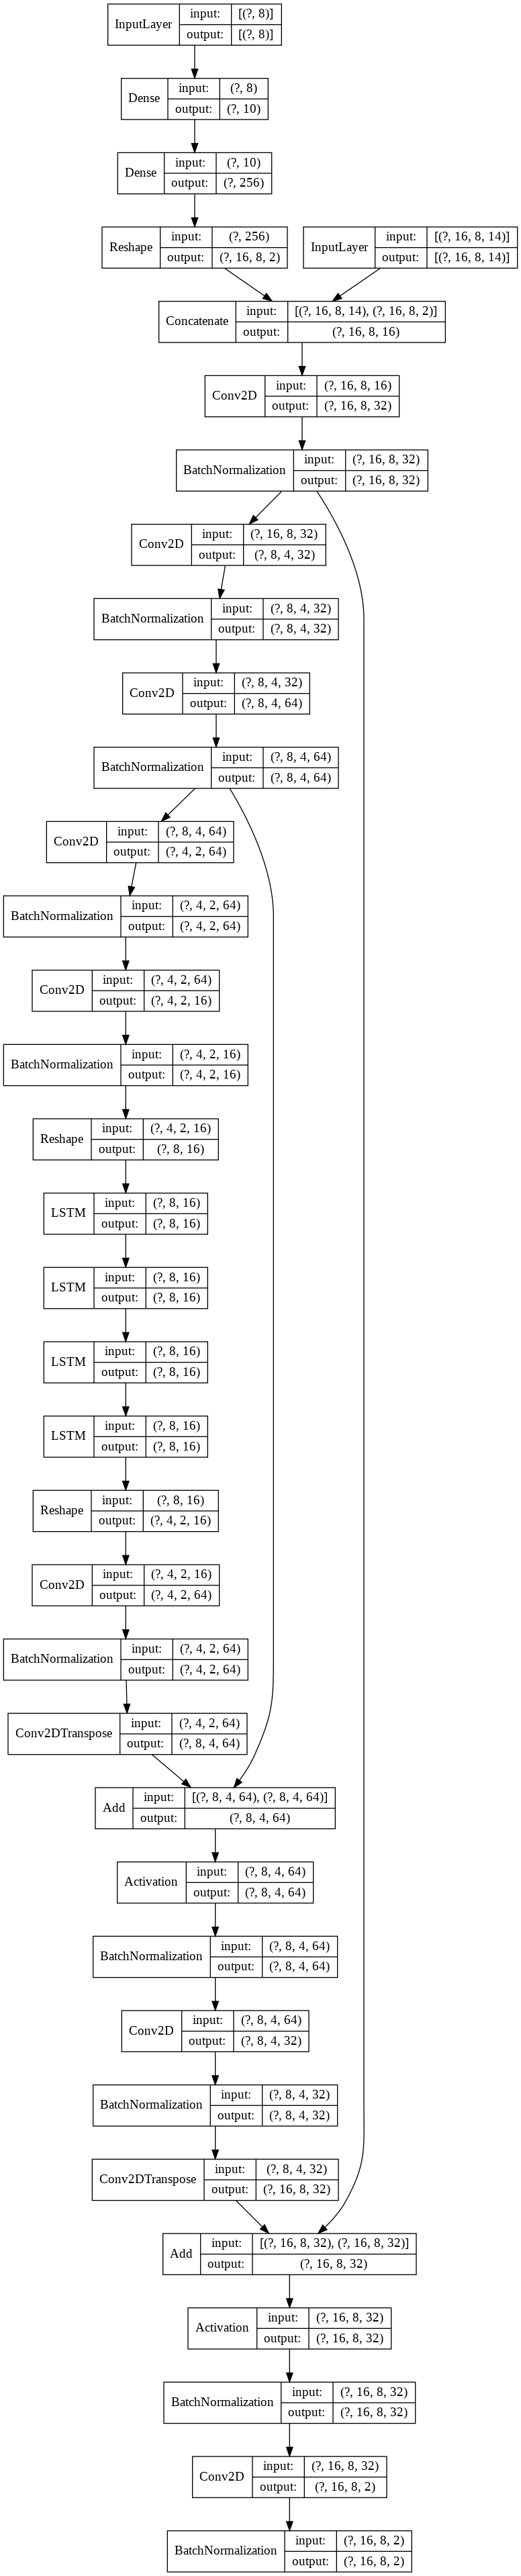

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file=f'BikeNYC_{model_name}.png', show_shapes=True, show_layer_names=False)

In [10]:
# train model
print("training model...")
ts = time.time()
history = model.fit(X_train, Y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(X_val,Y_val),
                    # callbacks=[early_stopping, model_checkpoint],
                    callbacks=[model_checkpoint],
                    verbose=2)
model.save_weights(os.path.join(
    'MODEL', '{}.h5'.format(hyperparams_name)), overwrite=True)
pickle.dump((history.history), open(os.path.join(
    path_result, '{}.history.pkl'.format(hyperparams_name)), 'wb'))
print("\nelapsed time (training): %.3f seconds\n" % (time.time() - ts))

training model...
Epoch 1/100
234/234 - 5s - loss: 1.6134 - rmse: 1.2696 - val_loss: 0.6727 - val_rmse: 0.8149
Epoch 2/100
234/234 - 5s - loss: 1.4377 - rmse: 1.1986 - val_loss: 2.0385 - val_rmse: 1.4275
Epoch 3/100
234/234 - 5s - loss: 0.7814 - rmse: 0.8812 - val_loss: 0.3389 - val_rmse: 0.5819
Epoch 4/100
234/234 - 5s - loss: 0.6616 - rmse: 0.8132 - val_loss: 0.4588 - val_rmse: 0.6773
Epoch 5/100
234/234 - 5s - loss: 0.6076 - rmse: 0.7794 - val_loss: 0.4990 - val_rmse: 0.7064
Epoch 6/100
234/234 - 4s - loss: 0.5577 - rmse: 0.7466 - val_loss: 0.4900 - val_rmse: 0.7000
Epoch 7/100
234/234 - 5s - loss: 0.5110 - rmse: 0.7146 - val_loss: 0.4562 - val_rmse: 0.6754
Epoch 8/100
234/234 - 5s - loss: 0.4671 - rmse: 0.6832 - val_loss: 0.4189 - val_rmse: 0.6472
Epoch 9/100
234/234 - 4s - loss: 0.4258 - rmse: 0.6523 - val_loss: 0.3805 - val_rmse: 0.6168
Epoch 10/100
234/234 - 5s - loss: 0.3869 - rmse: 0.6218 - val_loss: 0.3520 - val_rmse: 0.5933
Epoch 11/100
234/234 - 5s - loss: 0.3506 - rmse: 0.

In [11]:
# evaluate
model.load_weights(fname_param)
# model.load_weights('MODEL/BikeNYC.c3.p1.t1.lr0.00015.best.h5')
score = model.evaluate(
    X_test, Y_test, batch_size=Y_test.shape[0], verbose=0)
print('Test score: %.6f rmse (norm): %.6f rmse (real): %.6f' %
        (score[0], score[1], score[1] * (mmn._max - mmn._min) / 2.))

Test score: 0.001389 rmse (norm): 0.037271 rmse (real): 4.975625
